In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

This notebook will clean the data step by step, we will start with 5 datasets:
- NETSData with Addresses
- NAICS2022_RAFI.csv
- NAICS 6 digit
- SIC Code 
- states geojson

Our output will be 2 datasets:
- auction info that contains all the auction house information filtered by SIC code
- flux data detailing the number of openings and closings of auction houses from 1991 to 2021.

In [87]:
companies = pd.read_csv('data/raw/NETSData2022_RAFI(WithAddresses).txt', delimiter = '\t', encoding = 'ISO-8859-1')
naics = pd.read_csv('data/raw/NAICS2022_RAFI.csv')
industry = pd.read_csv('data/raw/2022-NAICS-Codes-6-digit.csv')
sic_code = pd.read_csv('data/raw/RAFI_SIC.csv')

/var/folders/gb/7v068m41117fznc0hh2hds0r0000gn/T/ipykernel_4729/2103225.py:1: DtypeWarning:

Columns (286,287,288,289,290,291,292) have mixed types. Specify dtype option on import or set low_memory=False.



In [88]:
naics_columns = [col for col in naics.columns if 'NAICS' in col]
naics_columns_reversed = naics_columns[::-1]
naics['Latest_NAICS'] = naics[naics_columns_reversed].bfill(axis=1).iloc[:, 0]
naics['First_NAICS'] = naics[naics_columns].bfill(axis = 1).iloc[:,0]
(naics['First_NAICS'] == naics['Latest_NAICS']).count()

71032

In [89]:
companies = companies.merge(naics, on = 'DunsNumber')
industry_count = companies.groupby('Latest_NAICS')[['DunsNumber']].count().reset_index().sort_values(by = 'DunsNumber')
industry_count.merge(industry, left_on = 'Latest_NAICS', right_on = 'NAICS22 Code')

,Latest_NAICS,DunsNumber,NAICS22 Code,NAICS22 Text
0,339994.0,1,339994,"Broom, Brush, and Mop Manufacturing"
1,339999.0,1,339999,All Other Miscellaneous Manufacturing
2,423120.0,1,423120,Motor Vehicle Supplies and New Parts Merchant ...
3,423140.0,1,423140,Motor Vehicle Parts (Used) Merchant Wholesalers
4,423210.0,1,423210,Furniture Merchant Wholesalers
...,...,...,...,...
404,445240.0,237,445240,Meat Retailers
405,311613.0,1093,311613,Rendering and Meat Byproduct Processing
406,311615.0,2225,311615,Poultry Processing
407,311611.0,8180,311611,Animal (except Poultry) Slaughtering


**Filtering Auction Houses**

In [90]:
auction = companies[companies['Latest_NAICS'] == 424520.0]
livestock_sic = sic_code[sic_code['NAICS17'] == 424520]

In [91]:
auction = auction.merge(livestock_sic, left_on = 'SIC8', right_on = 'SICCode')
auction = auction[auction['SICDescription'] == 'Auctioning livestock']
auction = auction.rename(columns = {'Compan':"Company", 'NAICS17_x': 'NAICS17'})
auction['Longitude'] = -1*auction['Longitude']

In [92]:
naics_columns = []
for i in range(1990,2023):
    naics_columns.append('NAICS' + str(i)[2:4])

In [93]:
def find_open_close_years(row):
    # Adjusting the year calculation based on the correct interpretation
    years = []
    for col in naics_columns:
        if not pd.isna(row[col]):
            year_suffix = int(col[-2:])
            year = (1900 + year_suffix) if year_suffix >= 90 else (2000 + year_suffix)
            years.append(year)
    opening_year = min(years) if years else None
    closing_year = max(years) if years else None
    # If the business was active in 2022, it's considered still open
    closing_year = 2022 if closing_year == 2022 else closing_year
    return opening_year, closing_year


In [94]:
auction['OpeningYear'], auction['ClosingYear'] = zip(*auction.apply(find_open_close_years, axis=1))
auction[auction['OpeningYear'] == 1990]
auction.to_csv('data/auction_info.csv')

In [98]:
open_flux = pd.DataFrame(auction['OpeningYear'].value_counts())
open_flux = open_flux.sort_values(by = 'OpeningYear').reset_index().rename(columns = {'OpeningYear':'Year', 'count':'Count'})

close_flux= pd.DataFrame(auction['ClosingYear'].value_counts())
close_flux = close_flux.sort_values(by = 'ClosingYear').reset_index().rename(columns = {'ClosingYear':'Year', 'count':'Count'})

In [111]:
flux = open_flux.merge(close_flux, on = 'Year')
flux = flux[(flux['Year'] != 1990)]
flux = flux[(flux['Year'] != 2022)]

In [112]:
flux

,Year,Count_x,Count_y
1,1991,48,61
2,1992,30,40
3,1993,169,38
4,1994,132,51
5,1995,173,92
6,1996,121,117
7,1997,241,95
8,1998,110,112
9,1999,101,124
10,2000,67,87


In [113]:
flux.to_csv('data/flux.csv')

**data visualization**

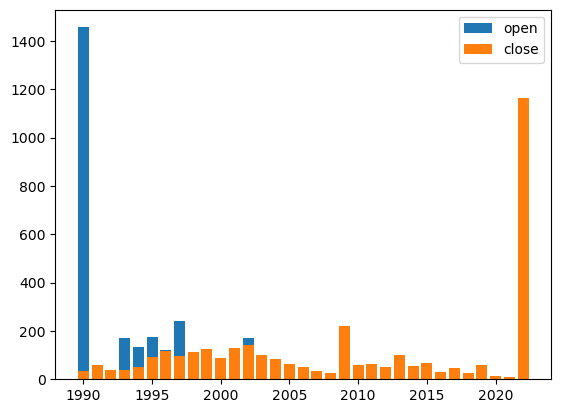

In [107]:
plt.bar(open_flux.iloc[:, 0], open_flux.iloc[:,1], label = 'open')
plt.bar(close_flux.iloc[:, 0], close_flux.iloc[:,1], label = 'close')
plt.legend()

**Geographic Info**

Text(0.5, 1.0, 'Number of Auction Houses in 2022')

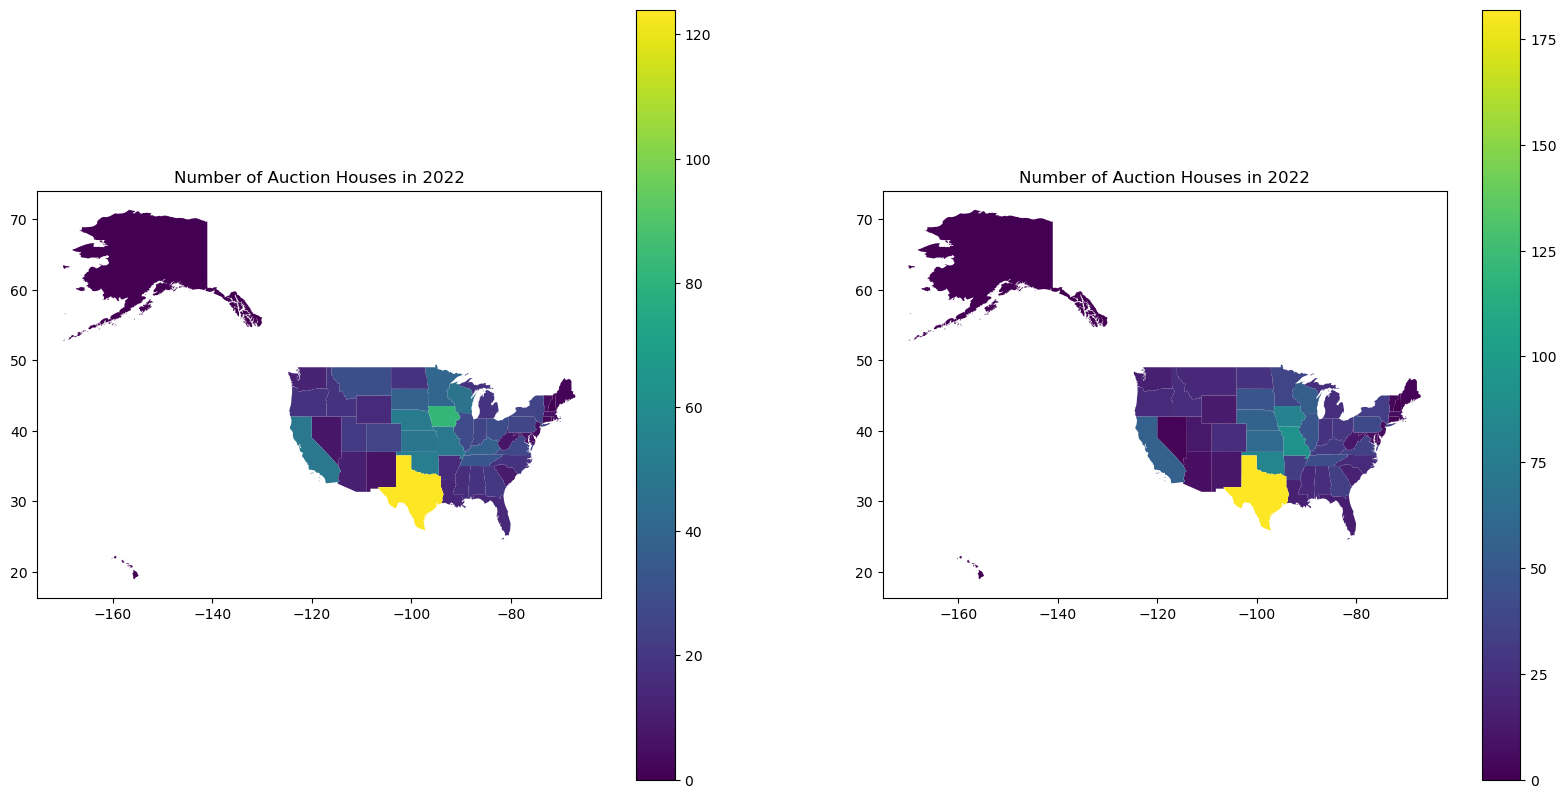

In [62]:
auction_map = auction.groupby('State').count().reset_index()[['State','NAICS22','NAICS90']]
us_map = gpd.read_file('data/raw/states.geojson')

map_df = us_map.merge(auction_map, how='left', left_on='STUSPS',right_on='State')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

map_df.plot(ax=ax1,column='NAICS22', cmap='viridis', legend=True)
ax1.set_title('Number of Auction Houses in 2022')

map_df.plot(ax=ax2,column='NAICS90', cmap='viridis', legend=True)
ax2.set_title('Number of Auction Houses in 2022')

In [63]:
fig = px.choropleth(map_df,
                    geojson=map_df.geometry,
                    locations=map_df.index,
                    color='NAICS22',  # This is the column you want to use for color scale
                    hover_name='State',  # This is the column you want to show on hover
                    hover_data={'NAICS22': True, 'NAICS90' : True}, 
                    labels={'NAICS22': 'Count in 2022', 'NAICS90': 'Count in 1990'},
                    title = 'Auction House geographic information(2022)'
                    )
fig.show()



**Years in Business**

In [64]:
year = []
for i in range(1990,2023):
    column_name = 'NAICS' + str(i)[2:4]
    year.append(column_name)

auction['Years in Business'] = auction[year].count(axis=1)
auction['Years in Business'].describe()

count    3455.000000
mean       15.272648
std        11.214511
min         1.000000
25%         5.000000
50%        13.000000
75%        25.000000
max        33.000000
Name: Years in Business, dtype: float64

**Revenue for Auction Houses Over the years**

In [65]:
def calculate_revenue(df):
    revenue = []
    auction_count = []
    for i in range(1990,2023):
        sales = "Sales"+str(i)[2:4]
        count = 'NAICS'+str(i)[2:4]
        revenue.append(round(df[sales].sum()/1000000,2))
        auction_count.append(df[count].count())
    return revenue, auction_count

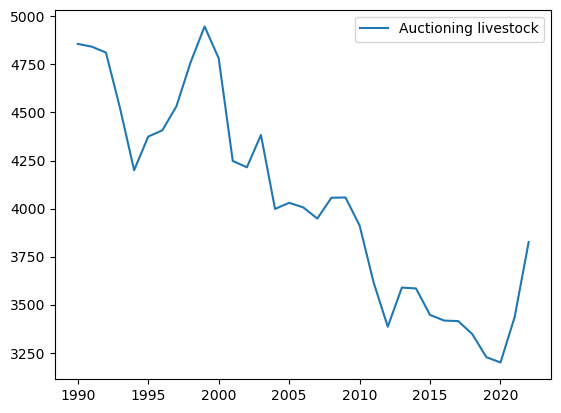

In [66]:
cattle = auction[auction['SICDescription'] == 'Cattle']

for i in auction['SICDescription'].unique():
    revenue, count = calculate_revenue(auction[auction['SICDescription'] == i])
    plt.plot(range(1990, 2023), revenue, label = i)
plt.legend()                                                           

In [67]:
auction_revenue_overtime = pd.DataFrame({'Year': range(1990, 2023)})
auction_revenue_overtime['Revenue(Millions)'] = calculate_revenue(auction)[0]
auction_revenue_overtime['Revenue/Auction(Thousands)'] = [round(a / b * 1000, 2) for a, b in zip(revenue, count)]
auction_revenue_overtime['Count'] = calculate_revenue(auction)[1]



Text(0.5, 1.0, 'Revenue of auction houses over the years')

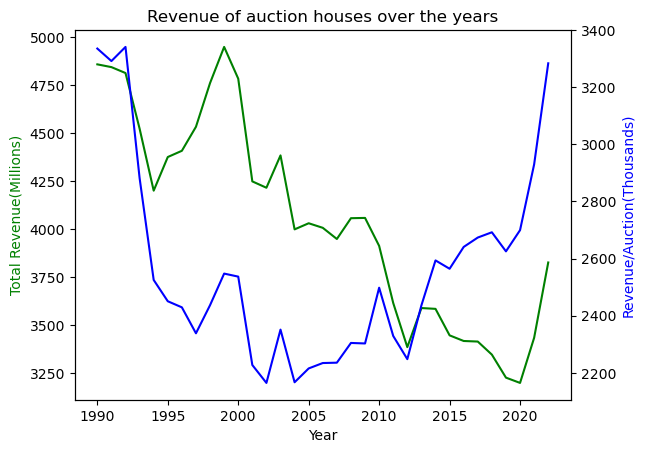

In [68]:
fig, ax1 = plt.subplots()

ax1.plot(auction_revenue_overtime['Year'], auction_revenue_overtime['Revenue(Millions)'], 'g-')  # 'g-' is for green solid line
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Revenue(Millions)', color='g')

ax2 = ax1.twinx()  
ax2.plot(auction_revenue_overtime['Year'], auction_revenue_overtime['Revenue/Auction(Thousands)'], 'b-')  
ax2.set_ylabel('Revenue/Auction(Thousands)', color='b')
plt.title("Revenue of auction houses over the years")


Text(0.5, 1.0, 'Count of Auction Houses(1990-2022)')

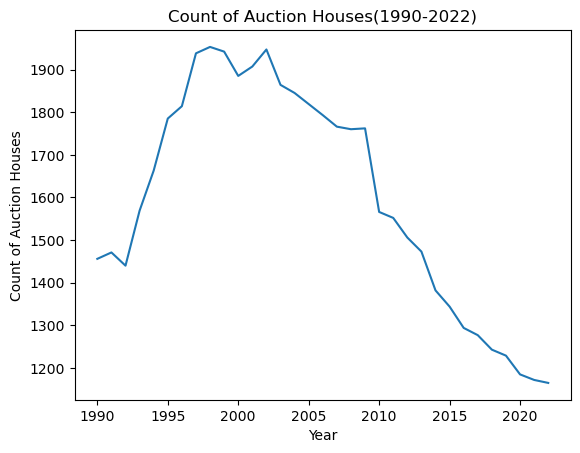

In [69]:
plt.plot(auction_revenue_overtime['Year'], auction_revenue_overtime['Count'])
plt.xlabel('Year')
plt.ylabel('Count of Auction Houses')
plt.title('Count of Auction Houses(1990-2022)')
